In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Layer, Input
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
from optuna import Trial
import random
import os

In [15]:
# Set fixed seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [16]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r'filtered_data.csv')

# Drop any unnamed columns (columns with 'Unnamed' in their name)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Set the 'time' column as the index of the DataFrame
df.set_index('time', inplace=True)

# Filter the time between 5:00 and 20:00
df = df.between_time('05:00', '20:00')

# Remove any rows with negative values in numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns
df = df[(df[numerical_columns] >= 0).all(axis=1)]

# View the cleaned dataset
print("First 5 rows of the cleaned dataset:")
display(df.head())

# Check for missing values in the cleaned dataset
print("Checking for missing values in the cleaned dataset:")
display(df.isnull().sum())

# Save the cleaned dataset to a new CSV file
df.to_csv('cleaned_filtered_data.csv')

First 5 rows of the cleaned dataset:


,total_solar_irradiance,direct_normal_irradiance,global_horizontal_irradiance,air_temperature,atmosphere,relative_humidity,power
time,,,,,,,
2019-01-01 05:00:00,1.0,240.0,1.0,0.5,1036.5,81.2,0.22
2019-01-01 05:15:00,1.0,240.0,1.0,0.6,1036.8,80.5,0.22
2019-01-01 05:30:00,1.0,240.0,1.0,0.7,1036.7,80.3,0.22
2019-01-01 05:45:00,1.0,240.0,1.0,0.7,1036.5,80.1,0.22
2019-01-01 06:00:00,1.0,240.0,1.0,0.7,1036.5,79.3,0.22


Cleaned dataset dimensions: (26404, 7)
Checking for missing values in the cleaned dataset:


total_solar_irradiance          0
direct_normal_irradiance        0
global_horizontal_irradiance    0
air_temperature                 0
atmosphere                      0
relative_humidity               0
power                           0
dtype: int64

In [17]:
# Define time intervals
train_start = '2019-01-01'
train_end = '2020-05-13'
val_start = '2020-05-14'
val_end = '2020-08-08'
test_start = '2020-08-09'
test_end = '2020-12-31'

# Split the data
train_df = df.loc[train_start:train_end]
val_df = df.loc[val_start:val_end]
test_df = df.loc[test_start:test_end]

# Display the shape of each set
print(f"Training set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")

Training set: (19290, 7)
Validation set: (3141, 7)
Test set: (3973, 7)


In [18]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Select only numeric columns for scaling
numeric_columns = train_df.select_dtypes(include=[np.number]).columns

# Fit the scaler on the training set and transform it
train_scaled = scaler.fit_transform(train_df[numeric_columns])

# Apply scaler.transform to validation and test sets
val_scaled = scaler.transform(val_df[numeric_columns])
test_scaled = scaler.transform(test_df[numeric_columns])

# Convert back to DataFrame with the same index and columns
train_scaled = pd.DataFrame(train_scaled, index=train_df.index, columns=numeric_columns)
val_scaled = pd.DataFrame(val_scaled, index=val_df.index, columns=numeric_columns)
test_scaled = pd.DataFrame(test_scaled, index=test_df.index, columns=numeric_columns)


In [22]:
def create_sequences(data, target_column, time_steps=54, forecast_horizon=4):
    X, y, timestamps = [], [], []
    # -time_steps - forecast_horizon + 1 to avoid going out of the DataFrame boundaries
    for i in range(len(data) - time_steps - forecast_horizon + 1):
        # Take a "window" of length time_steps
        X.append(data.iloc[i : i + time_steps].values)
        
        # Target values after forecast_horizon steps
        # Instead of just one value, we now predict the next 'forecast_horizon' values
        y.append(data.iloc[i + time_steps : i + time_steps + forecast_horizon][target_column].values)
        
        # Save the timestamp for the last predicted value in the horizon
        timestamps.append(data.index[i + time_steps + forecast_horizon - 1])
        
    return np.array(X), np.array(y), np.array(timestamps)


In [23]:
TIME_STEPS = 24  # Using the last 24 steps (6 hours) as "history"
FORECAST_HORIZON = 4  # Forecasting 4 steps ahead (1 hour)

TARGET_COLUMN = 'power'

# Creating sequences for training data
X_train, y_train, _ = create_sequences(train_scaled, TARGET_COLUMN,
                                       time_steps=TIME_STEPS,
                                       forecast_horizon=FORECAST_HORIZON)

# Creating sequences for validation data
X_val, y_val, _ = create_sequences(val_scaled, TARGET_COLUMN,
                                   time_steps=TIME_STEPS,
                                   forecast_horizon=FORECAST_HORIZON)

# Creating sequences for test data
X_test, y_test, test_timestamps = create_sequences(test_scaled, TARGET_COLUMN,
                                                   time_steps=TIME_STEPS,
                                                   forecast_horizon=FORECAST_HORIZON)

# Print the shape of the sequences
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (19263, 24, 7), (19263, 4)
Validation data shape: (3114, 24, 7), (3114, 4)
Test data shape: (3946, 24, 7), (3946, 4)


In [24]:
# Implementation of the multiplicative attention mechanism

from tensorflow.keras.regularizers import l2 

class AttentionLayer(Layer):
    def __init__(self, attention_dim, regularization=0.0, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.attention_dim = attention_dim
        self.regularization = regularization

    def build(self, input_shape):
        # Weight matrix for transforming encoder outputs (this is the key transformation)
        self.W_q = Dense(self.attention_dim, kernel_regularizer=l2(self.regularization))
        self.W_k = Dense(self.attention_dim, kernel_regularizer=l2(self.regularization))
        super(AttentionLayer, self).build(input_shape)

    def call(self, encoder_outputs):
        # Transform encoder outputs for query and key (query and key will be the same in this case)
        query = self.W_q(encoder_outputs)  # (batch_size, time_steps, attention_dim)
        key = self.W_k(encoder_outputs)    # (batch_size, time_steps, attention_dim)

        # Calculate attention scores using dot product (multiplicative attention)
        score = tf.matmul(query, key, transpose_b=True)  # (batch_size, time_steps, time_steps)
        attention_weights = tf.nn.softmax(score, axis=-1)  # (batch_size, time_steps, time_steps)

        # Weighted sum of encoder outputs (context vector)
        context_vector = tf.matmul(attention_weights, encoder_outputs)  # (batch_size, time_steps, hidden_size)
        
        # Reduce along the time dimension (summarizing the context vector)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, hidden_size)

        return context_vector


In [25]:
def build_model(trial, input_shape):
    # Hyperparameters from Optuna
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_size = trial.suggest_categorical('hidden_size', [16, 32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    attention_dim = hidden_size
    attention_reg = trial.suggest_float('attention_reg', 0.0, 0.3)

    # Input Layer
    inputs = Input(shape=input_shape)
    x = inputs

    # LSTM Layers
    for i in range(n_layers):
        x = LSTM(hidden_size, activation='tanh', return_sequences=True)(x)
        x = Dropout(dropout_rate)(x)

    # Attention Layer
    attention_output = AttentionLayer(attention_dim=attention_dim, regularization=attention_reg)(x)

    # Dense Layer for Multi-Step Forecasting (4 data points ahead)
    outputs = Dense(4, activation='linear')(attention_output)

    # Define Model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile Model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae')

    return model


In [26]:
import optuna
import numpy as np

# Define the Optuna objective function
def objective(trial):
    # Build the model with the trial hyperparameters
    model = build_model(trial, input_shape=(X_train.shape[1], X_train.shape[2]))

    # Suggest batch size
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256]) 

    # Early stopping for better trial performance evaluation
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=batch_size, verbose=0, callbacks=[early_stopping])

    # Evaluate the performance using validation loss
    val_loss = np.min(history.history['val_loss']) 
    return val_loss


# Create a study 
study = optuna.create_study(study_name='ALSTM_hyperparameter_optimization', direction='minimize')

# Run the optimization for 10 trials
study.optimize(objective, n_trials=10)


# Print the best hyperparameters found
print("Best hyperparameters:")
print(study.best_params)


[I 2025-01-01 21:12:10,388] A new study created in memory with name: ALSTM_hyperparameter_optimization
[I 2025-01-01 21:17:23,003] Trial 0 finished with value: 0.10849500447511673 and parameters: {'n_layers': 1, 'hidden_size': 128, 'dropout_rate': 0.2350065817919219, 'learning_rate': 0.05692337209280263, 'attention_reg': 0.04715052637577114, 'batch_size': 64}. Best is trial 0 with value: 0.10849500447511673.
[I 2025-01-01 21:20:16,837] Trial 1 finished with value: 0.20101846754550934 and parameters: {'n_layers': 3, 'hidden_size': 32, 'dropout_rate': 0.19047403588523482, 'learning_rate': 0.0001727447958708413, 'attention_reg': 0.17179912277634038, 'batch_size': 256}. Best is trial 0 with value: 0.10849500447511673.
[I 2025-01-01 21:28:53,324] Trial 2 finished with value: 19.635223388671875 and parameters: {'n_layers': 2, 'hidden_size': 128, 'dropout_rate': 0.29159635244120097, 'learning_rate': 1.1390231306124847e-05, 'attention_reg': 0.12964065264429478, 'batch_size': 256}. Best is tria

Best hyperparameters:
{'n_layers': 3, 'hidden_size': 64, 'dropout_rate': 0.22085061525719393, 'learning_rate': 0.020334785444782625, 'attention_reg': 0.22692308735310407, 'batch_size': 64}


In [27]:
from tensorflow.keras.callbacks import EarlyStopping

# Retraining Model with the Best Hyperparameters
best_params = study.best_params

# Combine training and validation sets for final retraining
combined_scaled = pd.concat([train_scaled, val_scaled])

# Unpack three values and ignore timestamps for combined data
X_combined, y_combined, _ = create_sequences(
    combined_scaled, TARGET_COLUMN, TIME_STEPS
)

y_combined = np.reshape(y_combined, (y_combined.shape[0], 4))  # Reshaping y for 4-step forecasting

# Manually pass best parameters to build the model
def build_model_with_best_params(input_shape, best_params):
    # Hyperparameters from Optuna
    n_layers = best_params['n_layers']
    hidden_size = best_params['hidden_size']
    dropout_rate = best_params['dropout_rate']
    learning_rate = best_params['learning_rate']
    attention_dim = hidden_size  
    attention_reg = best_params['attention_reg']

    # Input Layer
    inputs = Input(shape=input_shape)
    x = inputs

    # LSTM Layers
    for i in range(n_layers):
        x = LSTM(hidden_size, activation='tanh', return_sequences=True)(x)
        x = Dropout(dropout_rate)(x)

    # Attention Layer
    attention_output = AttentionLayer(attention_dim=attention_dim, regularization=attention_reg)(x)

    # Dense Layer for Multi-Step Forecasting (4 data points ahead)
    outputs = Dense(4, activation='linear')(attention_output)

    # Define Model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile Model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae')

    return model

# Build model with the best hyperparameters
model = build_model_with_best_params(input_shape=(X_combined.shape[1], X_combined.shape[2]), best_params=best_params)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model with combined data and early stopping
history = model.fit(X_combined, y_combined, epochs=30, batch_size=best_params['batch_size'], validation_split=0.2, callbacks=[early_stopping], verbose=1)


Epoch 1/30
281/281 [==============================] - 23s 62ms/step - loss: 0.7560 - val_loss: 0.1591
Epoch 2/30
281/281 [==============================] - 16s 58ms/step - loss: 0.1278 - val_loss: 0.1168
Epoch 3/30
281/281 [==============================] - 17s 59ms/step - loss: 0.1152 - val_loss: 0.1740
Epoch 4/30
281/281 [==============================] - 17s 60ms/step - loss: 0.1076 - val_loss: 0.1155
Epoch 5/30
281/281 [==============================] - 17s 60ms/step - loss: 0.0982 - val_loss: 0.1428
Epoch 6/30
281/281 [==============================] - 17s 59ms/step - loss: 0.0943 - val_loss: 0.1045
Epoch 7/30
281/281 [==============================] - 17s 60ms/step - loss: 0.0893 - val_loss: 0.1017
Epoch 8/30
281/281 [==============================] - 17s 62ms/step - loss: 0.0889 - val_loss: 0.1108
Epoch 9/30
281/281 [==============================] - 17s 61ms/step - loss: 0.0872 - val_loss: 0.1218
Epoch 10/30
281/281 [==============================] - 17s 61ms/step - loss: 0.085

In [ ]:
model.summary()

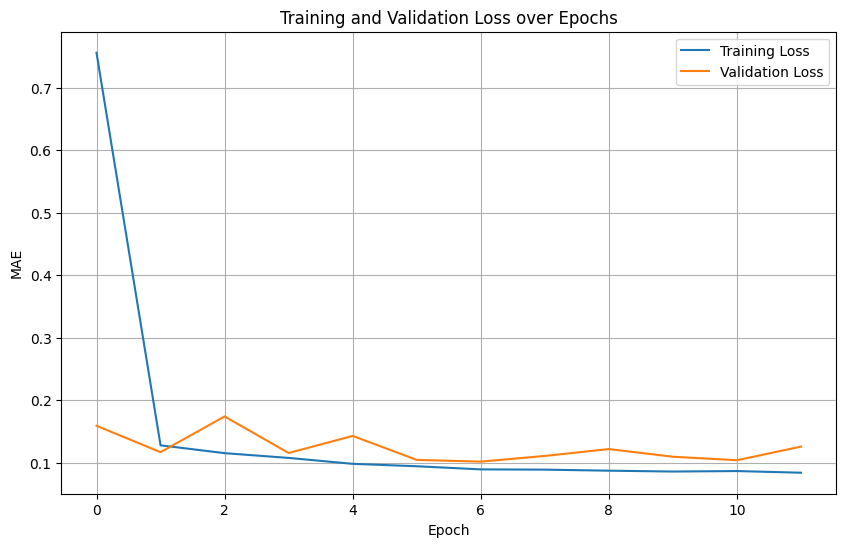

In [28]:
# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss_ATLSTM.png')
plt.show()

In [29]:
# Inverse scaling for y_pred_train (predicted values on training set)
y_pred_train = model.predict(X_train)

# Only select the predicted target values (1st column for regression target)
y_pred_train_target = y_pred_train[:, 0] 

# Inverse scaling only on the target values (predicted power)
y_pred_train_inv = scaler.inverse_transform(
    np.column_stack([np.zeros((len(y_pred_train_target), len(numeric_columns) - 1)), y_pred_train_target]))[:, -1]

# Inverse scaling for y_train (actual training set values)
train_inv = scaler.inverse_transform(train_scaled)
train_inv = pd.DataFrame(train_inv, columns=numeric_columns, index=train_scaled.index)
y_train_inv = train_inv[TARGET_COLUMN].values[TIME_STEPS:] 

# Inverse scaling for y_val (actual values on validation set)
val_inv = scaler.inverse_transform(val_scaled)
val_inv = pd.DataFrame(val_inv, columns=numeric_columns, index=val_scaled.index)
y_val_inv = val_inv[TARGET_COLUMN].values[TIME_STEPS:]  # Skip the first `TIME_STEPS` values

# Inverse scaling for y_pred_val (predicted values on validation set)
y_pred_val = model.predict(X_val)

# Only select the predicted target values
y_pred_val_target = y_pred_val[:, 0] 

# Inverse scaling only on the target values (predicted power)
y_pred_val_inv = scaler.inverse_transform(
    np.column_stack([np.zeros((len(y_pred_val_target), len(numeric_columns) - 1)), y_pred_val_target]))[:, -1]  

# Ensure that train_index and val_index are sliced properly for plotting
train_index = train_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_train_inv)]
val_index = val_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_val_inv)]

# Adjust y_train_inv and y_val_inv to match the sliced indices
y_train_inv = y_train_inv[:len(train_index)]
y_val_inv = y_val_inv[:len(val_index)]

# Adjust predicted values to match index lengths
y_pred_train_inv = y_pred_train_inv[:len(train_index)]
y_pred_val_inv = y_pred_val_inv[:len(val_index)]

98/98 [==============================] - 2s 16ms/step


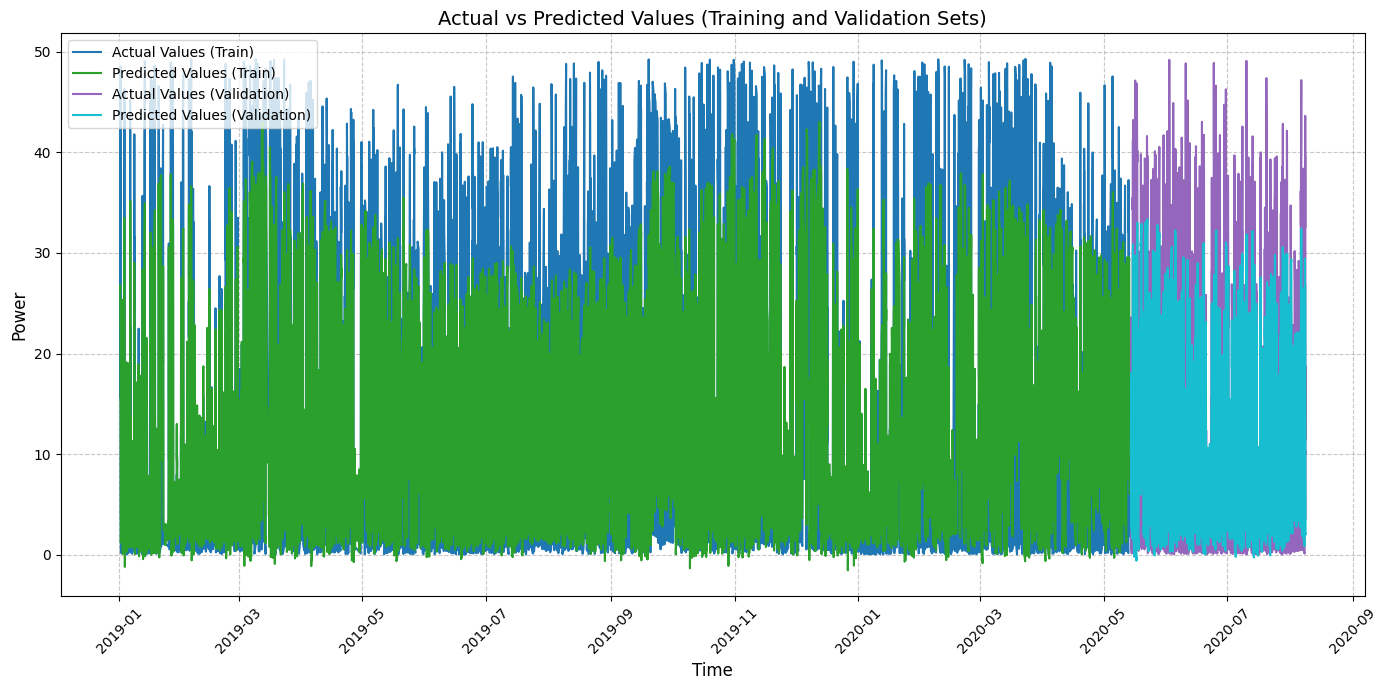

In [30]:
# Plot Actual vs Predicted Values for Training and Validation Sets
plt.figure(figsize=(14, 7))

# Updated color palette
train_actual_color = '#1f77b4' 
train_predicted_color = '#2ca02c' 
val_actual_color = '#9467bd'  
val_predicted_color = '#17becf' 

# Plot for Training Set
plt.plot(train_index, y_train_inv, label='Actual Values (Train)', color=train_actual_color)
plt.plot(train_index, y_pred_train_inv, label='Predicted Values (Train)', color=train_predicted_color)

# Plot for Validation Set
plt.plot(val_index, y_val_inv, label='Actual Values (Validation)', color=val_actual_color)
plt.plot(val_index, y_pred_val_inv, label='Predicted Values (Validation)', color=val_predicted_color)

# Add title and labels
plt.title('Actual vs Predicted Values (Training and Validation Sets)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)

# Move the legend to the top-left corner
plt.legend(fontsize=10, loc='upper left')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot with 300 DPI
plt.savefig("actual_vs_predicted_ALTSM.png", dpi=300)

# Show the plot
plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Training Set Metrics
mae_train = mean_absolute_error(y_train_inv, y_pred_train_inv)
rmse_train = np.sqrt(mean_squared_error(y_train_inv, y_pred_train_inv))
r2_train = r2_score(y_train_inv, y_pred_train_inv)

# Validation Set Metrics
mae_val = mean_absolute_error(y_val_inv, y_pred_val_inv)
rmse_val = np.sqrt(mean_squared_error(y_val_inv, y_pred_val_inv))
r2_val = r2_score(y_val_inv, y_pred_val_inv)

# Print the Results
print("Training Set Metrics:")
print(f"MAE: {mae_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"R²: {r2_train:.4f}")

print("\nValidation Set Metrics:")
print(f"MAE: {mae_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")
print(f"R²: {r2_val:.4f}")

Training Set Metrics:
MAE: 3.6673
RMSE: 5.6521
R²: 0.7877

Validation Set Metrics:
MAE: 3.7781
RMSE: 5.5344
R²: 0.7509


In [32]:
# Prediction on test set
y_pred = model.predict(X_test)

# Inverse scaling for y_test (actual values)
test_inv = scaler.inverse_transform(test_scaled)
test_inv = pd.DataFrame(test_inv, columns=numeric_columns, index=test_scaled.index)

124/124 [==============================] - 2s 17ms/step


In [33]:
# Prediction on test set
y_pred = model.predict(X_test)

# Only select the predicted target values (1st column for regression target)
y_pred_test_target = y_pred[:, 0] 

# Inverse scaling for y_pred_test (predicted values on test set)
y_pred_inv = scaler.inverse_transform(
    np.column_stack([np.zeros((len(y_pred_test_target), len(numeric_columns) - 1)), y_pred_test_target]))[:, -1]

# Inverse scaling for y_test (actual values on test set)
test_inv = scaler.inverse_transform(test_scaled)
test_inv = pd.DataFrame(test_inv, columns=numeric_columns, index=test_scaled.index)
y_test_inv = test_inv[TARGET_COLUMN].values[TIME_STEPS:]  # Skip the first `TIME_STEPS` values

# Align the test index
test_index = test_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_inv)]

# Ensure that y_test_inv and y_pred_inv have matching lengths for plotting
y_test_inv = y_test_inv[:len(test_index)]
y_pred_inv = y_pred_inv[:len(test_index)]



124/124 [==============================] - 2s 17ms/step


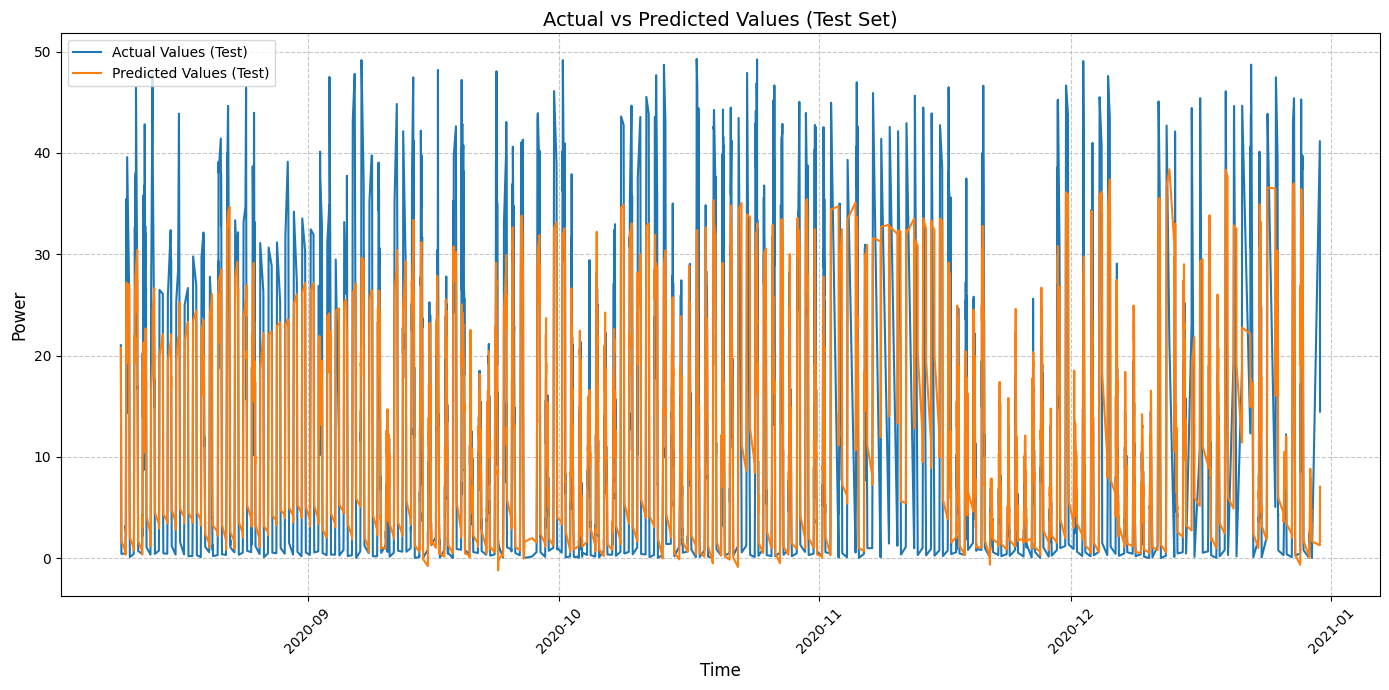

In [34]:
# Plot Actual vs Predicted Values for Test Set
plt.figure(figsize=(14, 7))

# Color palette with orange and blue
test_actual_color = '#1f77b4'  
test_predicted_color = '#ff7f0e'  

# Plot for Test Set
plt.plot(test_index, y_test_inv, label='Actual Values (Test)', color=test_actual_color)
plt.plot(test_index, y_pred_inv, label='Predicted Values (Test)', color=test_predicted_color)

# Add title and labels
plt.title('Actual vs Predicted Values (Test Set)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot with 300 DPI
plt.savefig("actual_vs_predicted_test_ALSTM.png", dpi=300)

# Show the plot
plt.show()


In [35]:
from datetime import datetime 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import os

# Calculate metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Save metrics to CSV
metrics = {
    'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2
}

metrics_df = pd.DataFrame([metrics])
metrics_file = 'ATLSTM_metrics.csv'

if not os.path.isfile(metrics_file):
    metrics_df.to_csv(metrics_file, index=False)
else:
    metrics_df.to_csv(metrics_file, mode='a', header=False, index=False)

print(f"Metrics saved to {metrics_file}")


MAE: 4.15
RMSE: 6.30
R²: 0.7211
Metrics saved to LSTM_metrics.csv


In [36]:
model.save('ATLSTM_model.h5')